# Train Caption-en model

Goal: Extract data information from caption labels

1. Classify opening and closing parentheses and others

2. Classify letters that appear in Month description and digits

Note: We include 't' as a possible letter to avoid confusion due to 'through' 


In [156]:
import os
import sys
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import re
from keras.preprocessing.image import ImageDataGenerator
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.externals import joblib

In [157]:
proj_root = os.path.abspath(os.path.join('../')) 
datadir = os.path.join(proj_root, 'data/caption/')
modeldir = os.path.join(proj_root, 'models/')
arcdir = os.path.join(proj_root, 'models/archive')

if not os.path.isdir(datadir): 
    print('data directory not found', os.path.abspath(datadir))
    raise
if not os.path.isdir(modeldir): os.path.makedirs(modeldir)
if not os.path.isdir(modeldir): os.path.makedirs(arcdir)

In [158]:
module_path = os.path.join(proj_root, 'kgschart')
sys.path.append(module_path)
from utils import pad_image

In [159]:
X = np.load(os.path.join(datadir, 'X-en.npy'))
Y = np.load(os.path.join(datadir, 'Y-en.npy'))

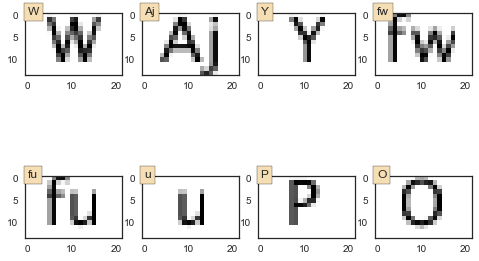

In [160]:
# convenient functions
def random_plot(X, Y, predicted=None):
    if len(Y) < 1: return
    sns.set_style('white')
    indices = np.random.choice(len(Y), min(8, len(Y)))
    count = 0
    for i in indices:
        count += 1
        ax = plt.subplot(2, 4, count)
        ax.imshow(X[i], cmap='gray')
        text = Y[i] if predicted is None else 'tr: %s, pr: %s' % (Y[i], predicted[i])
        ax.text(0, 0, text, bbox={'facecolor':"wheat"})
    plt.show(block=False)

random_plot(X, Y)


def compare_plot(X1, X2):
    sns.set_style('white')
    indices = range(3) if len(X1) <= 3 else np.random.choice(len(X1), 3)
    count = 0
    for i in indices:
        count += 1
        plt.subplot(3, 2, count)
        plt.imshow(X1[i], cmap='gray')
        count += 1
        plt.subplot(3, 2, count)
        plt.imshow(X2[i], cmap='gray')
    plt.show(block=False)

def generate_augmented_data(X, Y, target_size, seed=None):
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, 
                                 data_format='channels_last', channel_shift_range=0.5)
    out_X = None
    out_Y = None
    for x,y in datagen.flow(np.expand_dims(X, axis=4), Y, seed=seed):
        if out_X is None:
            out_X = x
            out_Y = y
        else:
            out_X = np.vstack([out_X, x])
            out_Y = np.concatenate([out_Y, y])
        if len(out_Y) >= target_size: 
            break
    out_X = out_X.squeeze()
    return out_X, out_Y


def diagnosis(fit, X, Y):
    print('accuracy = ', fit.score(X, Y))
    pred = fit.predict(X)
    wrong = (Y != pred)
    if np.any(wrong):
        random_plot(X[wrong], Y[wrong], pred[wrong])
    #print(classification_report(Y, pred))
    print(pd.crosstab(pd.Series(Y), pd.Series(pred), margins=True))

def ngram(x, n):
    out = set()
    for i in range(len(x)-n+1):
        item = x[i:(i+n)]
        if type(x) == str:
            out.add(item)
        else:
            out.add(tuple(item))
    return out 


In [161]:
# used for data preprocess
class Flatten:
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X.reshape(X.shape[0], -1)
    def get_params(self, deep=True):
        return {}


## Classification of date-relevant letters

Here, we remove irrelevant letters from samples.
Also, allow some confusion of letters with numbers

In [162]:
# ignore parentheses in text
Y = np.array([y.replace('(', '').replace(')', '') for y in Y])

# relevant letters
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'JuI', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

month1 = sum([list(ngram(x, 1)) for x in month_names], [])
month2 = sum([list(ngram(x, 2)) for x in month_names], [])
month3 = ['(' + x[0] for x in month_names]
dig_sym = [s for s in '0123456789(),']

date_relevant = month1 + month2 + month3 + dig_sym + ['t', 'th']
print(', '.join(date_relevant))

# keep only cases of relevant letters
incl = np.array([y in date_relevant for y in Y])
Y = Y[incl]
X = X[incl]
np.unique(Y)

a, n, J, e, F, b, a, r, M, r, p, A, a, M, y, u, n, J, u, l, J, u, I, J, u, g, A, S, e, p, c, O, t, o, v, N, D, c, e, Ja, an, eb, Fe, Ma, ar, Ap, pr, ay, Ma, un, Ju, ul, Ju, uI, Ju, Au, ug, ep, Se, Oc, ct, No, ov, De, ec, (J, (F, (M, (A, (M, (J, (J, (J, (A, (S, (O, (N, (D, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, (, ), ,, t, th


array([',', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'D',
       'F', 'I', 'J', 'M', 'N', 'O', 'S', 'a', 'ay', 'b', 'c', 'e', 'g',
       'l', 'n', 'o', 'ov', 'p', 'r', 't', 'u', 'v', 'y'], 
      dtype='<U3')

In [163]:
# next, we will incorporate fuzzy ness
fuzzy_list = [('I', '1'),
              ('l', '1'),
              ('O', '0'),
              ('S', '5'),
              ('Z', '2'),
              ('b', '6'),
              ('g', '9')]
for i in range(len(fuzzy_list)):
    Y = [y.replace(fuzzy_list[i][0], fuzzy_list[i][1]) for y in Y]
Y = np.array(Y) 
np.unique(Y)


array([',', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'D',
       'F', 'J', 'M', 'N', 'a', 'ay', 'c', 'e', 'n', 'o', 'ov', 'p', 'r',
       't', 'u', 'v', 'y'], 
      dtype='<U2')

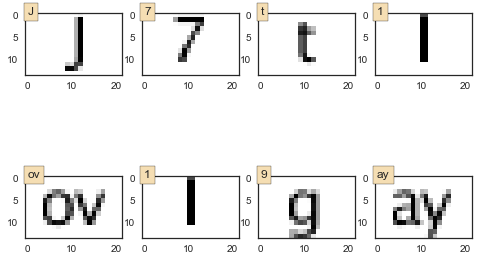

((39, 14, 22), (39,))

In [164]:
random_plot(X, Y)
X.shape, Y.shape

0 13 4 17


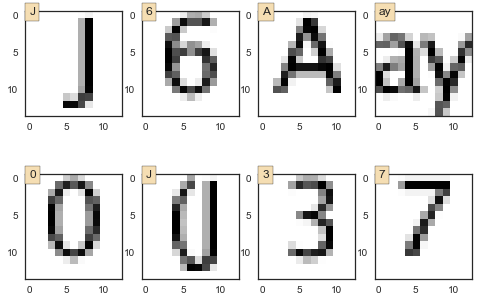

In [165]:
# crop letters as possible
i1 = np.inf
i2 = -1
j1 = np.inf
j2 = -1
for i in range(len(X)):
    nonbg = (X[i,:,:]<1)  # flag for non blank cells
    nonbg_rows = np.any(nonbg, axis=1)  # flg for rows with some non-blank cells
    nonbg_cols = np.any(nonbg, axis=0)  # flg for cols with some non-blank cells

    a1 = np.min(nonbg_rows.nonzero()[0])
    a2 = np.max(nonbg_rows.nonzero()[0])
    b1 = np.min(nonbg_cols.nonzero()[0])
    b2 = np.max(nonbg_cols.nonzero()[0])
    
    i1 = min(i1, a1)
    i2 = max(i2, a2)
    j1 = min(j1, b1)
    j2 = max(j2, b2)

print(i1,i2,j1,j2)

X = X[:, i1:(i2+1), j1:(j2)]
random_plot(X, Y)



(39, 14, 13) (39,)
(39, 17, 16) (39,)


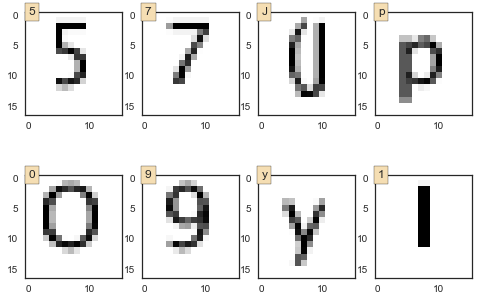

In [166]:
# pad slightly
target_rows = int(np.ceil(X.shape[1]*1.2))
target_cols = int(np.ceil(X.shape[2]*1.2))

print(X.shape, Y.shape)

tmp = [pad_image(X[i], target_rows, target_cols, 1.0) for i in range(len(X))]
tmp = [a.reshape(1, a.shape[0], a.shape[1]) for a in tmp]
X = np.vstack(tmp)
print(X.shape, Y.shape)
random_plot(X, Y)


In [167]:
# generate test data from image data generator
X_test, Y_test = generate_augmented_data(X, Y, 10000, seed = 8)

# generate train data too
X_train, Y_train = generate_augmented_data(X, Y, 5000, seed = 7)

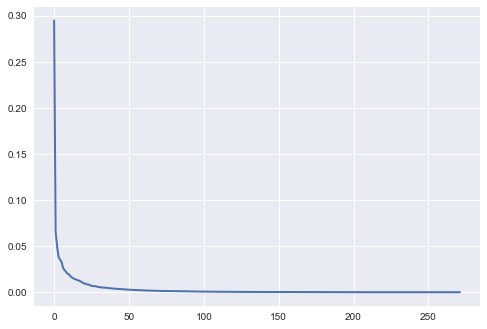

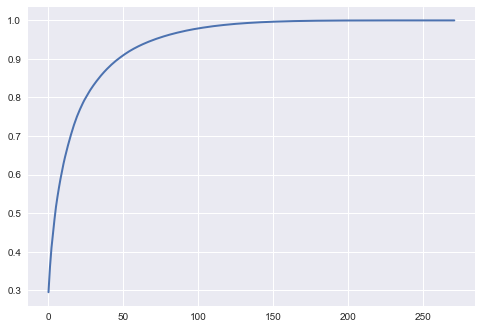

1 0.294786552714
2 0.360390947638
3 0.410031163686
4 0.448179967123
5 0.483624999619
6 0.516304672641
7 0.542545515122
8 0.566450276667
9 0.588466013528
10 0.608505020618
11 0.627717160628
12 0.644898466226
13 0.660749081816
14 0.675577319238
15 0.689857481813
16 0.703351324976
17 0.71619985784
18 0.728622647814
19 0.739965481012
20 0.750455092938
21 0.759819195386
22 0.769123493231
23 0.777555648959
24 0.785879356854
25 0.793515451866
26 0.800352035655
27 0.807038038915
28 0.813562384777
29 0.819966480796
30 0.825769400819
31 0.831407572391
32 0.836804178745
33 0.841993817669
34 0.846981839005
35 0.85191955509
36 0.856670949993
37 0.861225349203
38 0.865494384698
39 0.869720247803
40 0.873768315583
41 0.877657620319
42 0.881421585163
43 0.885076573461
44 0.888530919733
45 0.891947454178
46 0.895216571969
47 0.898271545774
48 0.901231677595
49 0.904183449172
50 0.907019288405
51 0.909783845504
52 0.912495128049
53 0.915128236631
54 0.91763973525
55 0.920048546224
56 0.922392133011
57 0

In [168]:
pipe_pca = Pipeline([
    ('flatten', Flatten()), 
    ('PCA', PCA())
])

pipe_pca.fit(X_train)
sns.set()
plt.plot(pipe_pca.named_steps['PCA'].explained_variance_ratio_, linewidth=2)
plt.show(block=False)

cum = pipe_pca.named_steps['PCA'].explained_variance_ratio_.cumsum()
plt.plot(cum, linewidth=2)
plt.show(block=False)
for i in range(len(cum)):
    print(i+1, cum[i])


accuracy on original set =  1.0
accuracy =  0.980730830671


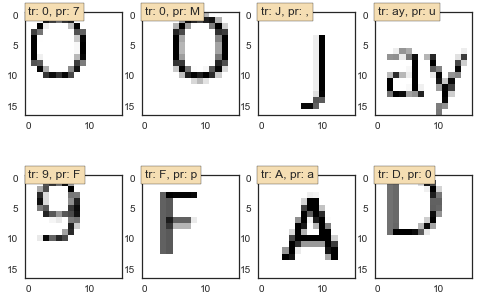

col_0    ,    0    1    2    3    4    5    6    7    8  ...      n    o   ov  \
row_0                                                    ...                    
,      256    0    0    0    0    0    0    0    0    0  ...      0    0    0   
0        0  505    0    0    0    0    0    0    2    0  ...      0    0    0   
1        0    0  771    0    0    0    0    0    0    0  ...      0    0    0   
2        0    0    0  256    0    0    0    0    0    0  ...      0    0    0   
3        0    0    2    0  253    0    0    0    1    0  ...      0    0    0   
4        0    0    0    0    0  251    2    0    0    0  ...      0    0    0   
5        0    1    0    0    4    0  504    0    0    5  ...      0    0    0   
6        0    1    0    0    0    0    0  503    0    5  ...      0    2    0   
7        0    0    1    0    0    0    0    0  255    0  ...      0    0    0   
8        0    0    0    0    1    0    1    8    0  244  ...      0    0    0   
9        0    0    0    0   

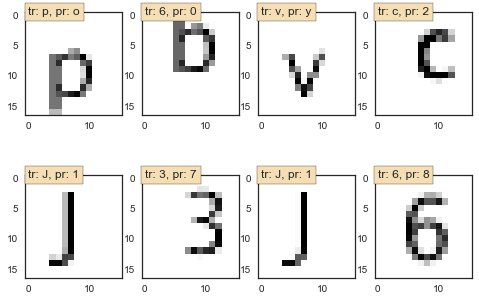

col_0    ,    0    1    2    3    4    5    6    7    8  ...      n    o   ov  \
row_0                                                    ...                    
,      256    0    0    0    0    0    0    0    0    0  ...      0    0    0   
0        0  505    0    0    0    0    0    0    2    0  ...      0    0    0   
1        0    0  771    0    0    0    0    0    0    0  ...      0    0    0   
2        0    0    0  256    0    0    0    0    0    0  ...      0    0    0   
3        0    0    2    0  253    0    0    0    1    0  ...      0    0    0   
4        0    0    0    0    0  251    2    0    0    0  ...      0    0    0   
5        0    1    0    0    4    0  504    0    0    5  ...      0    0    0   
6        0    1    0    0    0    0    0  503    0    5  ...      0    2    0   
7        0    0    1    0    0    0    0    0  255    0  ...      0    0    0   
8        0    0    0    0    1    0    1    8    0  244  ...      0    0    0   
9        0    0    0    0   

In [169]:
pipe_mlp = Pipeline([
    ('flatten', Flatten()), 
    ('PCA', PCA(n_components=50)),
    ('MLP', MLPClassifier((50,50), alpha=0.01))
])    

pipe_mlp.fit(X_train, Y_train)


print('accuracy on original set = ', pipe_mlp.score(X, Y))
diagnosis(pipe_mlp, X_test, Y_test)
diagnosis(pipe_mlp, X_test, Y_test)

In [170]:
np.random.seed(87)

# create data prep pipeline and
# fit pca before learning
# this way, we can fix the features to pass to MLP
# if we use incrementalPCA and fit online, then the MLP learning would 
# mess up since there is no guarantee that PCA component i now is the 
# same as the component i in the next fitted PCA
pca = PCA(n_components=50)
pipe_prep = Pipeline([
    ('flatten', Flatten()), 
    ('PCA', pca)
])
pipe_prep.fit(X_train)

#model = MLPClassifier((100,100,100), alpha=0.001, warm_start=True)
model = MLPClassifier((50,50), alpha=0.001, warm_start=True,
                      max_iter=10, batch_size=100)
pipe_pred = Pipeline([
    ('prep', pipe_prep),
    ('MLP', model)
])

classes = pipe_mlp.classes_


num = 0
result = None
counter = 0
consec_ones = 0
#for X_batch,Y_batch in train_gen.flow(np.expand_dims(X_in, axis=4), 
#                                      Y_in, batch_size=1000):
while counter <= 10000: 
    X_batch,Y_batch = generate_augmented_data(X, Y, 1000)
    counter += 1
    if counter > 10000: break
        
    model.partial_fit(pipe_prep.transform(X_batch.squeeze()), 
                      Y_batch, classes)
    num += len(Y_batch)
    
    score_test     = pipe_pred.score(X_test, Y_test)
    score_original = pipe_pred.score(X, Y)
    tmp = dict(size = [num], score_test = [score_test], 
               score_original = [score_original])
    tmp = pd.DataFrame(tmp)
    if result is None:
        result = tmp
    else:
        result = result.append(tmp)
    
    if counter % 100 == 1:
        print(num, 'score on test =', score_test,
              'score on original =', score_original)
    if score_test == 1.0 and score_original == 1.0:
        consec_ones += 1
    if consec_ones >= 10:
        print('DONE!')
        break

1007 score on test = 0.0688897763578 score on original = 0.102564102564
101707 score on test = 0.945986421725 score on original = 0.974358974359
202407 score on test = 0.986521565495 score on original = 1.0
303107 score on test = 0.995806709265 score on original = 1.0
403807 score on test = 0.998003194888 score on original = 1.0
504507 score on test = 0.999001597444 score on original = 1.0
605207 score on test = 0.999900159744 score on original = 1.0
DONE!


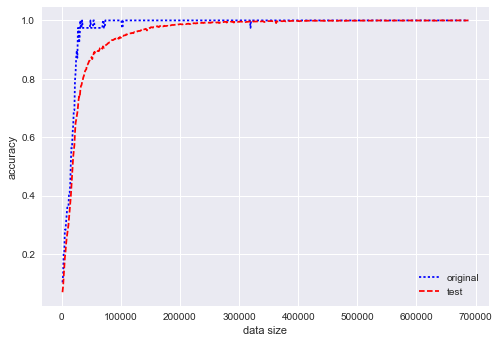

In [171]:
sns.set()
plt.plot(result['size'], result['score_original'], 'b:', label='original')
plt.plot(result['size'], result['score_test'], 'r--', label='test') 
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('data size')
plt.show(block=False)

In [172]:
savename = os.path.join(modeldir, 'caption-en_pca-loose-mlp-full.pkl')
pipe = Pipeline([('PCA', pca), ('MLP', model)])
joblib.dump(pipe, savename)

['C:\\Users\\Kota.Mori\\Documents\\_dev\\kgschart\\models/caption-en_pca-loose-mlp-full.pkl']

In [176]:
with open(os.path.join(modeldir, 'caption-en-loose-config.json'), 'w') as file:
    json.dump(dict(input_shape=X.shape[1:]), file)

(39, 17, 16)